# A sinusoidal weight matrix is most robust to noise

* If we want a circulant network to have stable activity with no input
* and the network is operating in the linear regime
* and the network needs to encode 2 variables (vector direction and magnitude)
* and the neurons can only have positive activities

Then the solution which provides the optimal noise resilience is:
* the activity is a sinusoid with period equal to the number of neurons, and minimum of 0
* the weight matrix is a also a sinusoid with nonzero mean (ie. Fourier modes 0 and 1 are non-zero)

Results:
* increasing the number of Fourier modes present in the weight matrix after the first 2 (which are required) increases the resulting noise linearly
  * having only Fourier modes 0 and 1 allows the weight matrix to perform low pass filtering on the noise and reject most of it
* increasing the number of neurons in the network allows for better noise rejection as the cutoff frequency is reduced

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.scale
plt.style.use('seaborn-notebook')
np.random.seed(7) # seed so plots are repeatable
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)

In [2]:
N = 32
neuron_indices = np.arange(N)
scaled_cosine = lambda neuron_indices, N: (1 + np.cos(2*np.pi*neuron_indices/N))/2
gaussian = lambda neuron_indices, N: np.exp(-(neuron_indices - N/2)**2 /4)

profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_spectrum = lambda fourier_spectrum: np.fft.ifft(fourier_spectrum).real

def fill_fourier_modes_up_to_N(last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements up to the `last_fourier_mode` filled with ones.
	
	`last_fourier_mode=0` corresponds to just the DC component being filled.
	
	For higher Fourier modes both the positive and negative frequency components are filled.
	
	eg. `fill_fourier_modes_up_to_N(1, 4) = [1,1,0,1]`
	'''
	assert last_fourier_mode <= period//2+1, f'last fourier mode of {last_fourier_mode} not possible with discrete Fourier vector of length {period}'
	half_fourier_vector = np.zeros(period//2+1)
	half_fourier_vector[:last_fourier_mode+1] = 1
	return np.hstack((half_fourier_vector, np.flip(half_fourier_vector[1:-1])))

a = scaled_cosine(neuron_indices, N)

In [3]:
def simulate_and_plot(a0, W, dt=0.001, repetitions=100, noise=0.3, plot=True, show=True):
	a = np.tile(a0, (repetitions,1)).T
	a += noise*np.random.randn(*a.shape)

	# simulate for 50000 time steps
	for _ in range(50000):
		delta_a = -a + W@a
		a += dt*delta_a
		if abs(delta_a).sum() < 1e-6:
			break

	error = a - a0.reshape(a0.size,1)
	mu = a.mean(axis=1)
	stdev = np.sqrt(a.var(axis=1))
	ms_error = np.mean(error**2, axis=0)
	ms_mean = ms_error.mean()
	ms_stdev = ms_error.std()
	assert mu.size == a0.size and stdev.size == a0.size, 'Not averaging over repetitions in the right direction'
	assert ms_error.size == repetitions, 'Not averaging over neurons in the right direction'

	if plot:
		plt.fill_between(neuron_indices, mu - stdev, mu + stdev, alpha=0.5, label='response stddev')
		plt.plot(neuron_indices, a[:,0], 'orange', label='example response')
		plt.plot(a0, 'k', label='original activity')
		plt.title(f'Average noise variance = {ms_mean:.4f}$\\pm${ms_stdev:.4f}')
		plt.legend()
		if show:
			plt.show()

	return ms_mean, ms_stdev

## Test how adding more Fourier modes effects the error

Fourier modes up to 1 = [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1.]


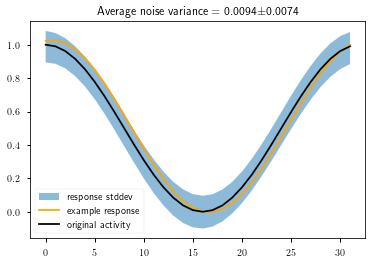

Fourier modes up to 3 = [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1.]


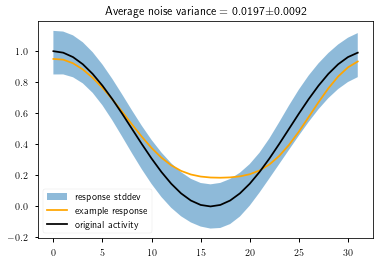

Fourier modes up to 5 = [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1.]


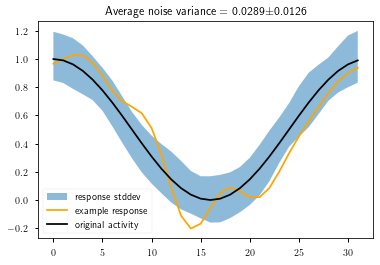

Fourier modes up to 7 = [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1.]


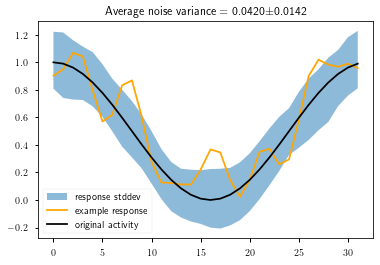

Fourier modes up to 9 = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


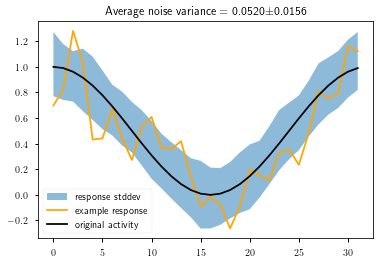

Fourier modes up to 11 = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


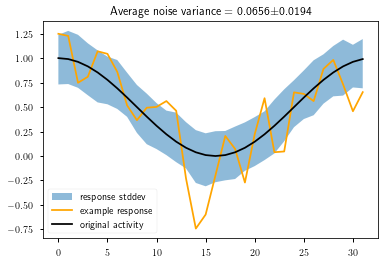

Fourier modes up to 13 = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


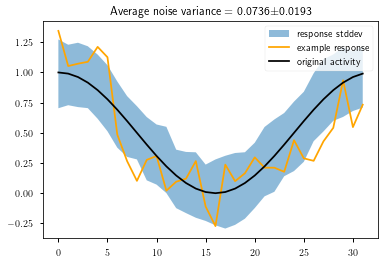

Fourier modes up to 15 = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


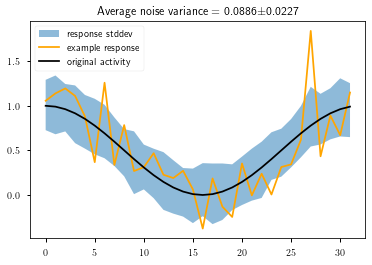

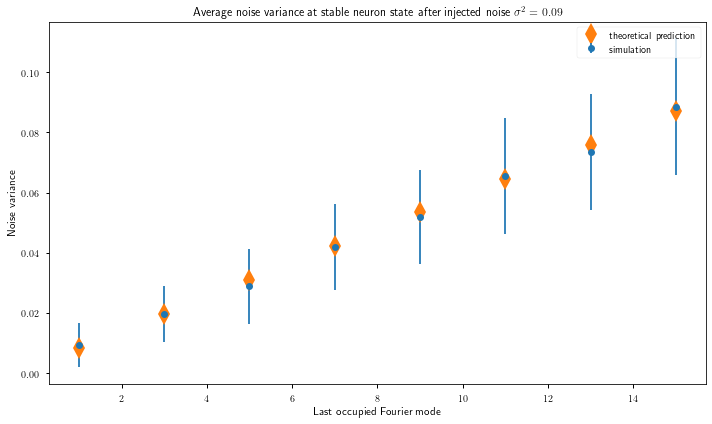

In [4]:
fourier_mode_errors = []
fourier_mode_stddevs = []
noise_stddev = 0.3
noise_var = noise_stddev**2

last_mode_range = np.arange(1,N//2+1,2)
for last_mode in last_mode_range:
	fw = fill_fourier_modes_up_to_N(last_mode, N)

	W = profile_to_matrix(get_cosine_from_fourier_spectrum(fw))

	print(f'Fourier modes up to {last_mode} = {fw}')
	ms_mean, ms_stddev = simulate_and_plot(a, W, noise=noise_stddev)
	fourier_mode_errors.append(ms_mean)
	fourier_mode_stddevs.append(ms_stddev)
plt.figure(figsize=(10,6))
plt.errorbar(last_mode_range, fourier_mode_errors, fourier_mode_stddevs, fmt='o', label='simulation')
plt.plot(last_mode_range, [noise_var/N*np.sum(fill_fourier_modes_up_to_N(last_mode, N)) for last_mode in last_mode_range], 'd', markersize=15, label='theoretical prediction')
plt.xlabel('Last occupied Fourier mode')
plt.ylabel('Noise variance')
plt.title(f'Average noise variance at stable neuron state after injected noise $\\sigma^2={noise_var}$')
plt.legend()
plt.tight_layout()
plt.show()

The noise variance increases linearly with the number of extra Fourier modes, as predicted

$$\textbf{Var}\left[||\omega \ast e||^2\right] = \frac{1}{N}||\omega||^2 \textbf{E}\left[||\epsilon||^2\right] = \frac{1}{N}\sum_f||\mathcal{F}_f[\omega]||^2 \textbf{E}\left[||\epsilon||^2\right]$$

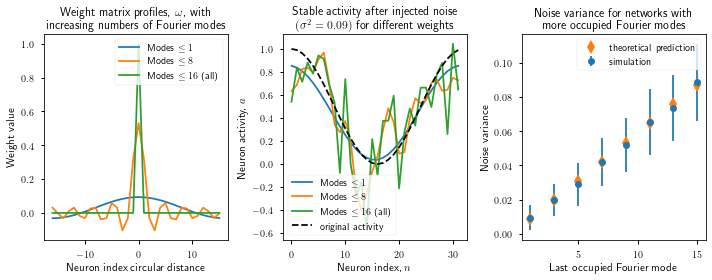

In [5]:
dt=0.001

noisy_activity = a + noise_stddev*np.random.randn(*a.shape)
W_normal = profile_to_matrix(get_cosine_from_fourier_spectrum(fill_fourier_modes_up_to_N(1, N)))
W_half = profile_to_matrix(get_cosine_from_fourier_spectrum(fill_fourier_modes_up_to_N(N//4, N)))
W_full = profile_to_matrix(get_cosine_from_fourier_spectrum(fill_fourier_modes_up_to_N(N//2+1, N)))

a_normal = noisy_activity.copy()
a_half = noisy_activity.copy()
a_full = noisy_activity.copy()
for _ in range(50000):
	a_normal += dt*(W_normal@a_normal - a_normal)
	a_half += dt*(W_half@a_half - a_half)
	a_full += dt*(W_full@a_full - a_full)

fig, axs = plt.subplots(1, 3, figsize=(10,4)) # paper figures should be width 10
axs[0].plot(neuron_indices-N//2, W_normal[N//2,:], label='Modes $\\leq 1$')
axs[0].plot(neuron_indices-N//2, W_half[N//2,:], label='Modes $\\leq 8$')
axs[0].plot(neuron_indices-N//2, W_full[N//2,:], label='Modes $\\leq 16$ (all)')
axs[0].set_xlabel('Neuron index circular distance')
axs[0].set_ylabel('Weight value')
axs[0].set_title('Weight matrix profiles, $\\omega$, with\nincreasing numbers of Fourier modes')
axs[0].legend()

axs[1].plot(neuron_indices, a_normal, label='Modes $\\leq 1$')
axs[1].plot(neuron_indices, a_half, label='Modes $\\leq 8$')
axs[1].plot(neuron_indices, a_full, label='Modes $\\leq 16$ (all)')
axs[1].plot(neuron_indices, a, 'k--', label='original activity')
axs[1].set_xlabel('Neuron index, $n$')
axs[1].set_ylabel('Neuron activity, $a$')
axs[1].set_title(f'Stable activity after injected noise\n$(\\sigma^2={noise_var})$ for different weights')
axs[1].legend()

axs[2].errorbar(last_mode_range, fourier_mode_errors, fourier_mode_stddevs, fmt='o', label='simulation')
plt.plot(last_mode_range, [noise_var/N*np.sum(fill_fourier_modes_up_to_N(last_mode, N)) for last_mode in last_mode_range], 'd', markersize=10, label='theoretical prediction')
axs[2].set_xlabel('Last occupied Fourier mode')
axs[2].set_ylabel('Noise variance')
axs[2].set_title(f'Noise variance for networks with\nmore occupied Fourier modes')
axs[2].legend()

plt.tight_layout()
plt.savefig('plots/sinusoidal-noise-rejection-fourier-modes.pdf')
plt.show()

## Test how increasing the number of neurons decreases the error

N = 4


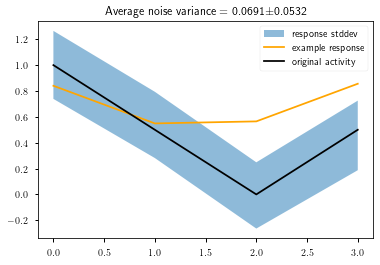

N = 8


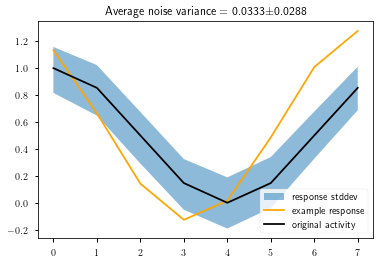

N = 16


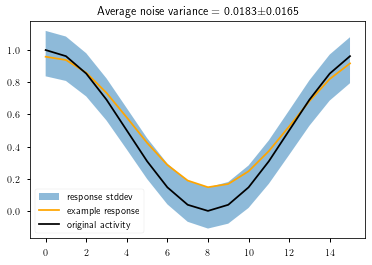

N = 32


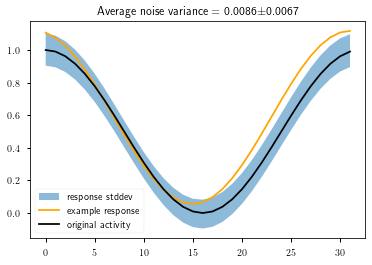

N = 64


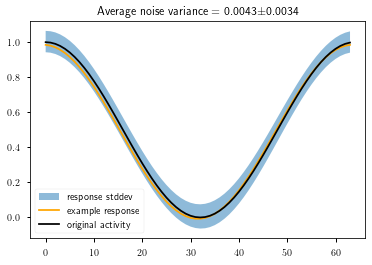

N = 128


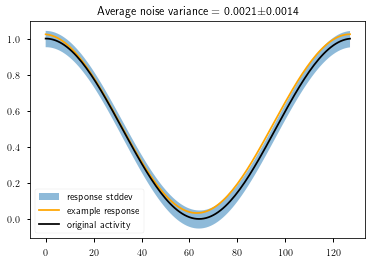

N = 256


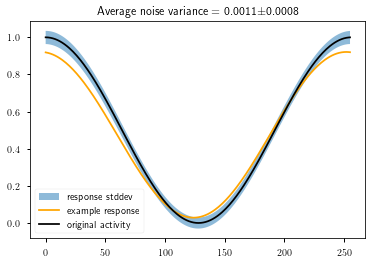

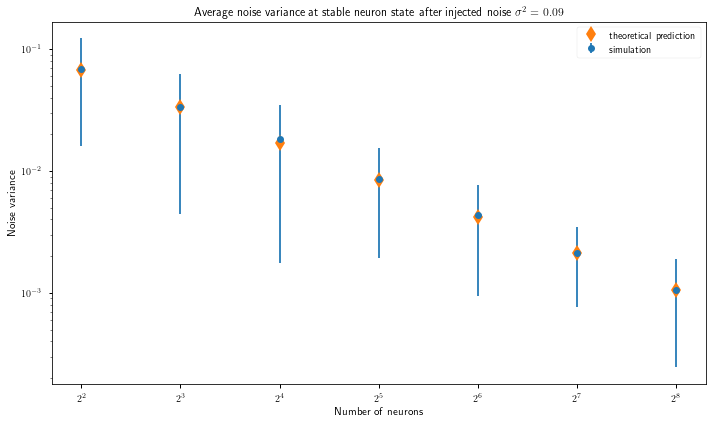

In [6]:
# test for the size of the network
num_neurons_errors = []
num_neurons_stddevs = []

N_range = (2**np.arange(2,9)).astype(np.uint32)
for N in N_range:
	fw = fill_fourier_modes_up_to_N(1, N)
	neuron_indices = np.arange(N)
	a = scaled_cosine(neuron_indices, N)

	W = profile_to_matrix(get_cosine_from_fourier_spectrum(fw))

	print(f'N = {N}')
	ms_mean, ms_stddev = simulate_and_plot(a, W, noise=noise_stddev)
	num_neurons_errors.append(ms_mean)
	num_neurons_stddevs.append(ms_stddev)
plt.figure(figsize=(10,6))
plt.errorbar(N_range, num_neurons_errors, num_neurons_stddevs, fmt='o', label='simulation')
plt.plot(N_range, noise_var*3/N_range, 'd', markersize=12, label='theoretical prediction')
plt.xlabel('Number of neurons')
plt.ylabel('Noise variance')
plt.title(f'Average noise variance at stable neuron state after injected noise $\\sigma^2={noise_var}$')
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.legend()
plt.tight_layout()
plt.savefig('plots/sinusoidal-noise-rejection-number-neurons.pdf')
plt.show()

The log of the variance decreases linearly with the log of the number of neurons. Ie. the noise variance decreases inversely proportionally to the number of neurons, as predicted.

Here we always fill up to fourier mode 1 - ie. 3 elements in the Fourier spectrum ($0, +f, -f$) so the expected variance is $3/N$ of the injected noise variance.

$$\textbf{Var}\left[||\omega \ast e||^2\right] = \frac{3}{N} \textbf{E}\left[||\epsilon||^2\right]$$